In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import nawrapper as nw
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot

In [3]:
import nawrapper.kfilter_share as kfilter

In [4]:
kx = 90
ky = 50
kx_apo = 0
ky_apo = 0
unpixwin = 1
d_th = 1/120.
data_root = '/tigress/zequnl/cmb/data/'

In [5]:
apopath = data_root + '/from_choi/apo_mask/deep56_c7v5_car_190220_rect_master_apo_w0.fits'
apo = enmap.read_map(apopath)

In [6]:
mask_raw = enmap.read_fits(data_root + "/from_choi/window/deep56_s14_pa1_f150_c7v5_car_190220_rect_w0_cl0.00nK_pt1.00_nt0.0_T.fits")
mask = enmap.extract(mask_raw, apo.shape, apo.wcs)

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


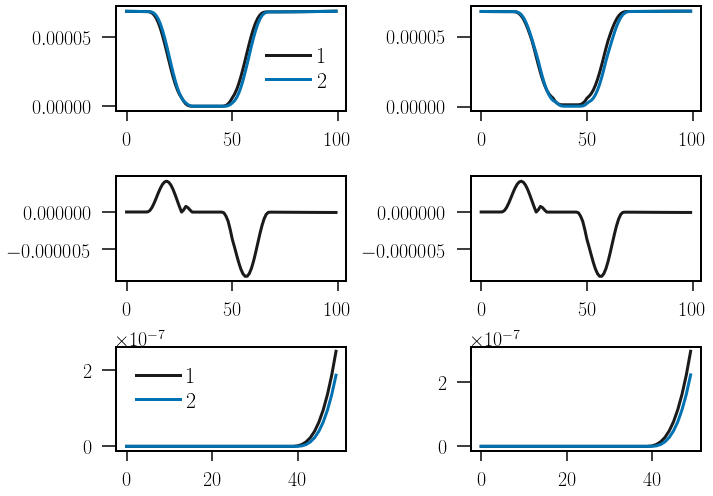

In [7]:
nw.debug_plot(mask, mask_raw)

In [8]:
# PA 1 -----
beam_filename = data_root + "/from_choi/beam/beam_tform_160201_s14_pa1_f150_jitter_CMB_deep56.txt"
beam_table = np.loadtxt(beam_filename)

lmax_beam = 30000
nsplits = 4

mapname_head = data_root + "/from_choi/maps/filtered/ACTPol_148_deep56_pa1_f150_s14_4way_split"
raw_maps = [enmap.read_map(f"{mapname_head}{i}_srcadd_I_filt_unpixwin.fits") for i in range(nsplits)]
steve_maps = [enmap.extract(rm, apo.shape, apo.wcs) for rm in raw_maps]

weird_apo = apo.copy()
weird_apo[np.isclose(weird_apo,0.0)] = np.inf

mapname_head = data_root + "/from_choi/maps/ACTPol_148_D56_pa1_f150_s14_4way_split"
raw_maps_f = [enmap.read_map(f"{mapname_head}{i}_srcadd_I.fits") for i in range(nsplits)]

boxed_maps_f = [enmap.zeros(apo.shape, apo.wcs) for i in range(nsplits)]
for i in range(nsplits):
    raw_maps_f[i].wcs.wcs.crpix -= np.array([1,1])
    enmap.extract(raw_maps_f[i], apo.shape, apo.wcs, omap=boxed_maps_f[i])

no_wcs_maps = [
    kfilter.get_map_kx_ky_filtered_pyfftw(m * apo,d_th,kx,kx_apo,ky,ky_apo,unpixwin=1,zero_pad=False)
    for m in boxed_maps_f]
maps = [enmap.zeros(apo.shape, wcs=apo.wcs, dtype=apo.dtype) for i in range(nsplits)]
for i in range(nsplits):
    maps[i][apo > 0.0] = no_wcs_maps[i][apo > 0.0] / apo[apo > 0.0]

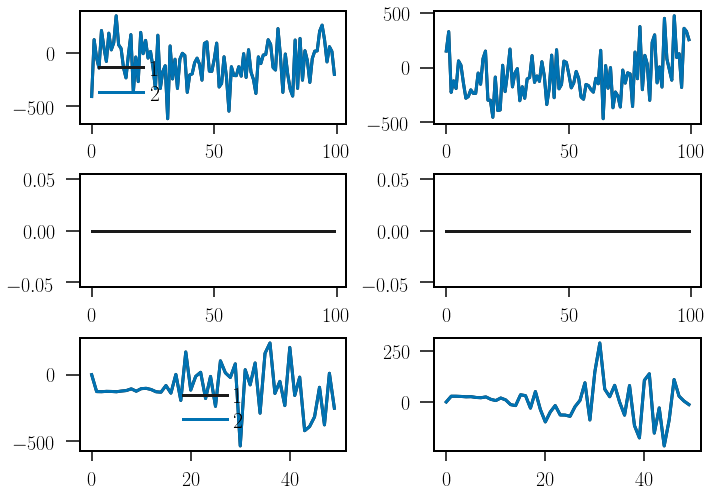

In [9]:
nw.debug_plot(maps[0], steve_maps[0], apo=apo, xoff=0, yoff=0)

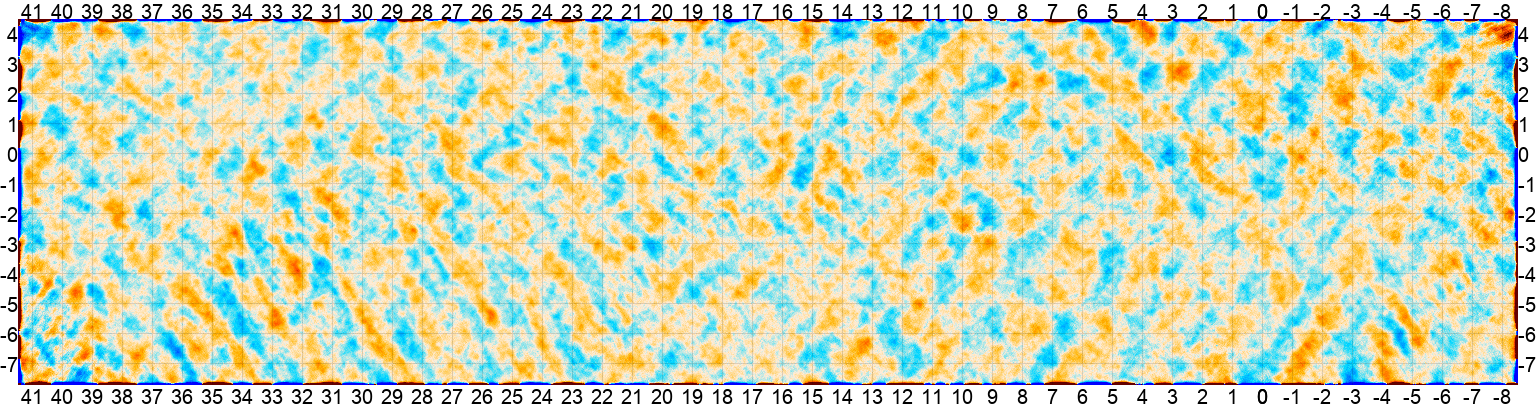

In [10]:
plots = enplot.get_plots(maps[0], range=1000, downgrade=4)
enplot.show(plots)

Text(0, 0.5, '$B_{\\ell}$')

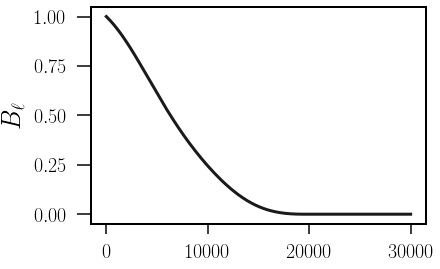

In [11]:
Bl = np.zeros(lmax_beam)
Bl[:beam_table.shape[0]] = beam_table[:,1].astype(float)
beam = Bl

plt.plot( np.arange(lmax_beam), beam)
plt.ylabel(r"$B_{\ell}$")

In [12]:
binleft, binright, bincenter = np.loadtxt( data_root + '/from_choi/binning/BIN_ACTPOL_50_4_SC_low_ell', unpack=True, 
                                          dtype={'names': ('binleft', 'binright', 'bincenter'),
                                                 'formats': ('i', 'i', 'f')})
lmax = 7925
ells = np.arange(lmax)
bpws=-1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft[1:], binright[1:])):
    bpws[bl:br+1] = i
    
weights = np.array([1.0 / np.sum(bpws == bpws[l]) for l in range(lmax)])
b =nmt.NmtBin(2048,bpws=bpws,ells=ells,weights=weights, lmax=lmax, is_Dell=True)
lb = b.get_effective_ells()

In [13]:
niter = 0 # NaMaster-CAR only supports niter=0

field0 = nmt.NmtField(mask, [maps[0]], beam=beam, wcs=mask.wcs, n_iter=niter)
field1 = nmt.NmtField(mask, [maps[1]], beam=beam, wcs=mask.wcs, n_iter=niter)

In [14]:
%%time

cl_coupled = nmt.compute_coupled_cell(field0, field1)
lb = b.get_effective_ells()
w0 = nmt.NmtWorkspace()
w0.compute_coupling_matrix(field0,field1, b, n_iter=niter)
Cb = w0.decouple_cell(cl_coupled)

CPU times: user 41min 28s, sys: 5.18 s, total: 41min 33s
Wall time: 1min 14s


In [15]:
ps_dict = {}
cross_spectra = []
fields = [nmt.NmtField(mask, [maps[i]], beam=beam, wcs=mask.wcs, n_iter=niter)
         for i in range(nsplits)]

# we can reuse the workspace w0 from earlier
for i in range(nsplits):
    for j in range(nsplits):
        if i >= j:
            cl_coupled = nmt.compute_coupled_cell(fields[i], fields[j])
            Cb = w0.decouple_cell(cl_coupled)
            ps_dict[f"{i},{j}"] = Cb
            if i > j:
                cross_spectra += [Cb[0]]

In [16]:
mean_Cltt = np.sum(cross_spectra, axis=0) / len(cross_spectra)
se_Cltt = np.std(cross_spectra, axis=0)/np.sqrt(len(cross_spectra))

(-100000000.0, 2500000000.0)

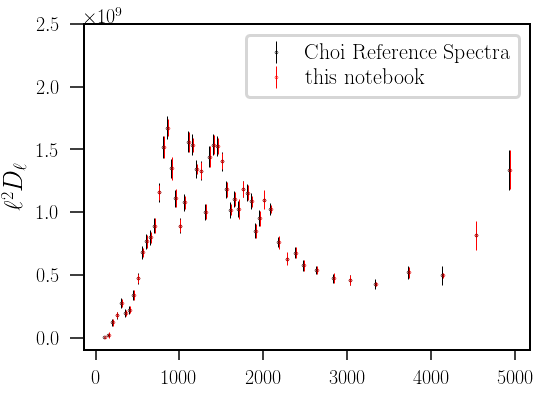

In [17]:
plt.figure(figsize=(8,6))

actual_cltt = np.loadtxt(data_root + "/from_choi/ps/deep56_s14_pa1_f150_c7v5_car_190220_rect_window0_TT_lmax7925_fsky0.01081284_output.txt")
choi_dl = actual_cltt[2:54,1]
choi_delta_dl = actual_cltt[2:54,2]
plt.errorbar( actual_cltt[2:54,0] , (choi_dl * actual_cltt[2:54,0]**2), 
             yerr = ( choi_delta_dl) * actual_cltt[2:54,0]**2, fmt='k.', lw=1, ms=1, label="Choi Reference Spectra" )

lbs = lb[1:-3]
notebook_dl = mean_Cltt[1:-3] 
plt.errorbar(lbs + 10, notebook_dl * lbs**2 , 
             fmt='r.', yerr=(notebook_dl / np.sqrt(2 * lbs + 1) + se_Cltt[1:-3]) * lbs**2  ,
             lw=1, ms=1, label="this notebook")
plt.ylabel(r"$\ell^2 D_{\ell}$")
plt.legend(frameon=True)
plt.ylim(-1e8, 2.5e9)

Text(0.5, 1.0, 'notebook / Choi')

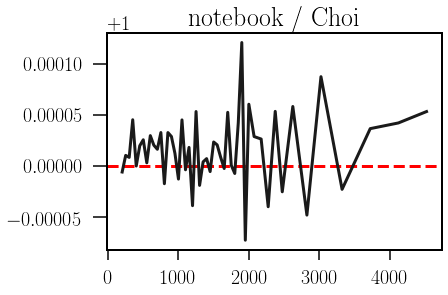

In [18]:
plt.axhline(1, ls='dashed', color='red')
plt.plot( lbs[2:-1], (mean_Cltt[1:-3]  / choi_dl)[2:-1])
plt.title("notebook / Choi")